# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_RNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_RNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = [64]
        drop_out = [0.5]
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        fc_input_size = np.int(np.prod(img_size) * input_shape[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x
    

In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_RNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    # prediction = ['boring', 'horrible', 'calm', 'funny']
    prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 1 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 1 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (169, 14, 129, 1)
Single output data size: (2,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTK_RNN_Net(
  (rnn1): LSTM(1806, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09765070974826813 0.06870254892661858 0.07137902482091227
Train/Val/TEST Accuracy: 69.56521739130434 38.888888888888886 61.904761904761905
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08669334799051284 0.06746716618605812 0.07431476453192383
Train/Val/TEST Accuracy: 71.01449275362319 55.55555555555556 52.38095238095238
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08733155578374863 0.06716648606703125 0.07323455999929658
Train/Val/TEST Accuracy: 72.46376811594203 55.55555555555556 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08123479932546615 0.06610083450585888 0.06850420469362732
Train/Val/TEST Accuracy: 75.3623188405797 61.111111111111114 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07553883716464042 0.06469438586565149 0.061881701822303944
Train/Val/TEST Accuracy: 85.5072463768116 77.77777777777777 76.19047619047619
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06297886967658997 0.06300492199241287 0.061804432676927

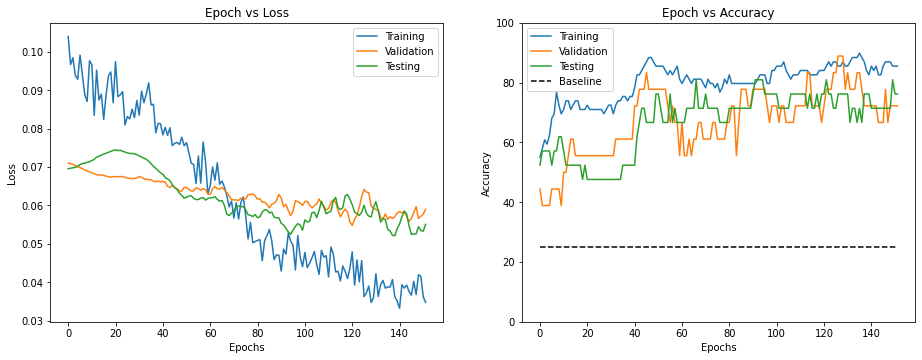

Train/Val/Test Final MSE: [0.047882959991693494, 0.054787113298920706, 0.06016481587375026]
Train/Val/Test Maximum Accuracy: [84.05797101449275, 72.22222222222223, 76.19047619047619]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09936902821063995 0.09151290752278227 0.07635225856765396
Train/Val/TEST Accuracy: 75.3623188405797 61.111111111111114 47.61904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08293310105800629 0.09197964178424121 0.07076461218457553
Train/Val/TEST Accuracy: 81.15942028985508 66.66666666666667 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08083887696266175 0.0954632075348248 0.06718198035135477
Train/Val/TEST Accuracy: 78.26086956521739 55.55555555555556 61.904761904761905
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08259382247924804 0.09496825242725511 0.06428308809907841
Train/Val/TEST Accuracy: 86.95652173913044 55.55555555555556 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.06144275516271591 0.09555879250789683 0.060941293907706584
Train/Val/TEST Accuracy: 88.40579710144928 61.111111111111114 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.055150880664587024 0.10227515243200792 0.058618554146

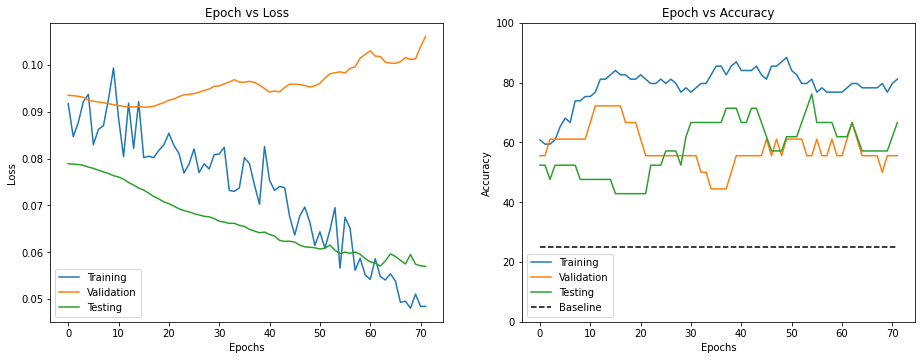

Train/Val/Test Final MSE: [0.07536514475941658, 0.0942183726777633, 0.06379759693074794]
Train/Val/Test Maximum Accuracy: [84.05797101449275, 55.55555555555556, 66.66666666666667]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08106855750083923 0.10874675649820882 0.0721165340319149
Train/Val/TEST Accuracy: 75.71428571428571 70.58823529411765 61.904761904761905
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08159413486719132 0.10837300231351572 0.07302764571310642
Train/Val/TEST Accuracy: 75.71428571428571 58.8235294117647 52.38095238095238
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.07950055003166198 0.10867560643921881 0.07402353721582108
Train/Val/TEST Accuracy: 65.71428571428571 58.8235294117647 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08065228685736656 0.10880474970840356 0.07324549610660012
Train/Val/TEST Accuracy: 65.71428571428571 58.8235294117647 42.857142857142854
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07306402176618576 0.10640703563523643 0.07118464834500282
Train/Val/TEST Accuracy: 72.85714285714286 64.70588235294117 47.61904761904762
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.07411941885948181 0.10331491391886682 0.07052276514115788


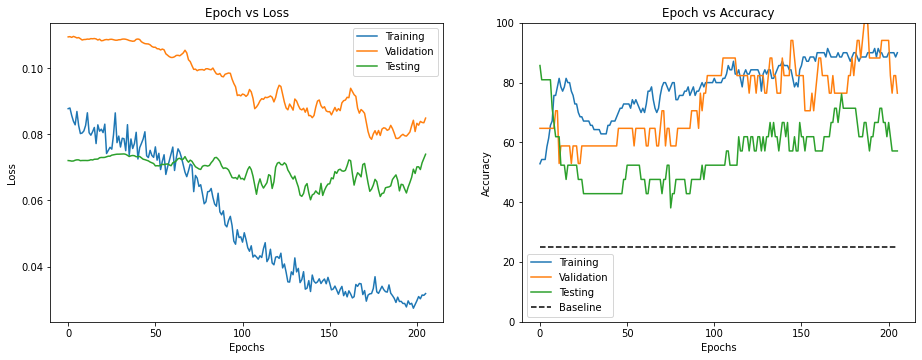

Train/Val/Test Final MSE: [0.03180915415287018, 0.07852867987993009, 0.0634416115048918]
Train/Val/Test Maximum Accuracy: [90.0, 76.47058823529412, 71.42857142857143]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09060254320502281 0.09028293800485485 0.07152325525835511
Train/Val/TEST Accuracy: 82.85714285714286 64.70588235294117 52.38095238095238
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08322219848632813 0.08869213452014853 0.07303745634341058
Train/Val/TEST Accuracy: 81.42857142857143 82.3529411764706 57.142857142857146
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08268730491399764 0.08890186803524985 0.07284733309712638
Train/Val/TEST Accuracy: 78.57142857142857 58.8235294117647 57.142857142857146
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08085192814469337 0.08806275390088558 0.07123550219416973
Train/Val/TEST Accuracy: 84.28571428571429 70.58823529411765 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07337790131568908 0.08949281165705007 0.0701111237119351
Train/Val/TEST Accuracy: 88.57142857142857 64.70588235294117 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06651582419872284 0.09360620647887974 0.07196533990403016

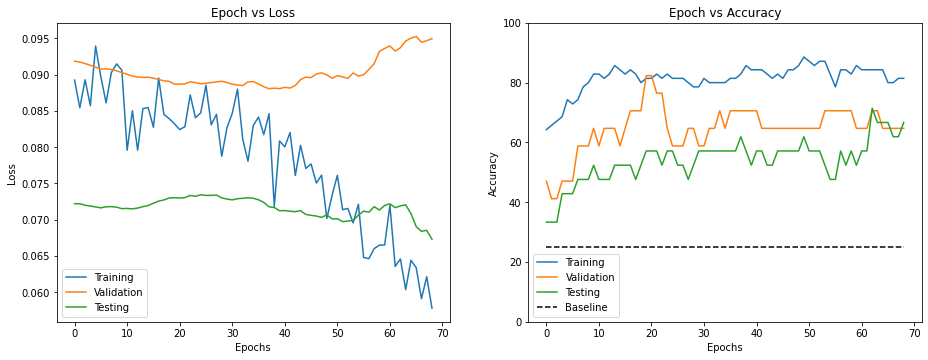

Train/Val/Test Final MSE: [0.08461575955152512, 0.08805287311620572, 0.07177604918113156]
Train/Val/Test Maximum Accuracy: [82.85714285714286, 70.58823529411765, 61.904761904761905]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08567247912287712 0.10419913655256524 0.07407534345016063
Train/Val/TEST Accuracy: 70.0 35.294117647058826 76.19047619047619
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08264532387256622 0.10367673843660775 0.07173732702454283
Train/Val/TEST Accuracy: 84.28571428571429 52.94117647058823 80.95238095238095
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08531746715307235 0.10258382504038951 0.0706640742208124
Train/Val/TEST Accuracy: 85.71428571428571 41.1764705882353 57.142857142857146
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08681618198752403 0.10508009144926772 0.06811937914972077
Train/Val/TEST Accuracy: 85.71428571428571 41.1764705882353 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0721138134598732 0.10427283013568205 0.06975785578556713
Train/Val/TEST Accuracy: 84.28571428571429 41.1764705882353 76.19047619047619
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.076259745657444 0.10399039034896038 0.06680525128640943
Train/Val/TEST Ac

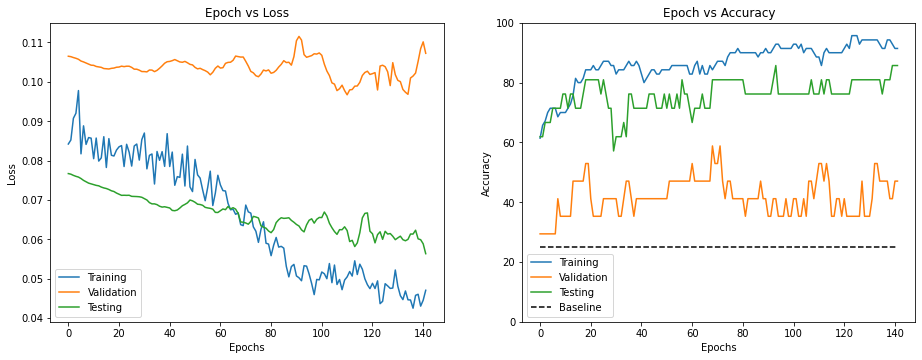

Train/Val/Test Final MSE: [0.050459904968738555, 0.09667928681215819, 0.06222044739739171]
Train/Val/Test Maximum Accuracy: [88.57142857142857, 52.94117647058823, 76.19047619047619]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)


In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.05802658468484878, 0.08245326515699561, 0.06428010417758265]
Train/Val/Test Average Accuracy: [85.90890269151139, 65.55555555555556, 70.47619047619048]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.40348127 0.47365928] with label  [0]
Target Example: [0.125 0.875] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.11931309103965759  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.2635741 0.3305586] with label  [0]
Target Example: [0.    0.375] with label  [0, 2]
Real Label Example: [10.  1. 10.  1.] with label  [0]
------- MSE: 0.03572316840291023  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.5896936  0.54323107] with label  [3]
Target Example: [0.125 0.375] with label  [0]
Real Label Example: [8. 1. 3. 1.] with label  [0]
------- MSE: 0.1221209168434143  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.3490921  0.42066965] with label  [0]
Target Example: [0.75 0.5 ] with label  [3]
Real Label Example: [1. 1. 5. 8.] with label  [3, 2]
------- MSE: 0.08351022750139236  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.34670323 0.5499809 ] with

## 2D emotion plot

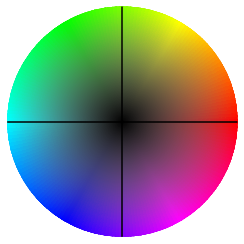

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


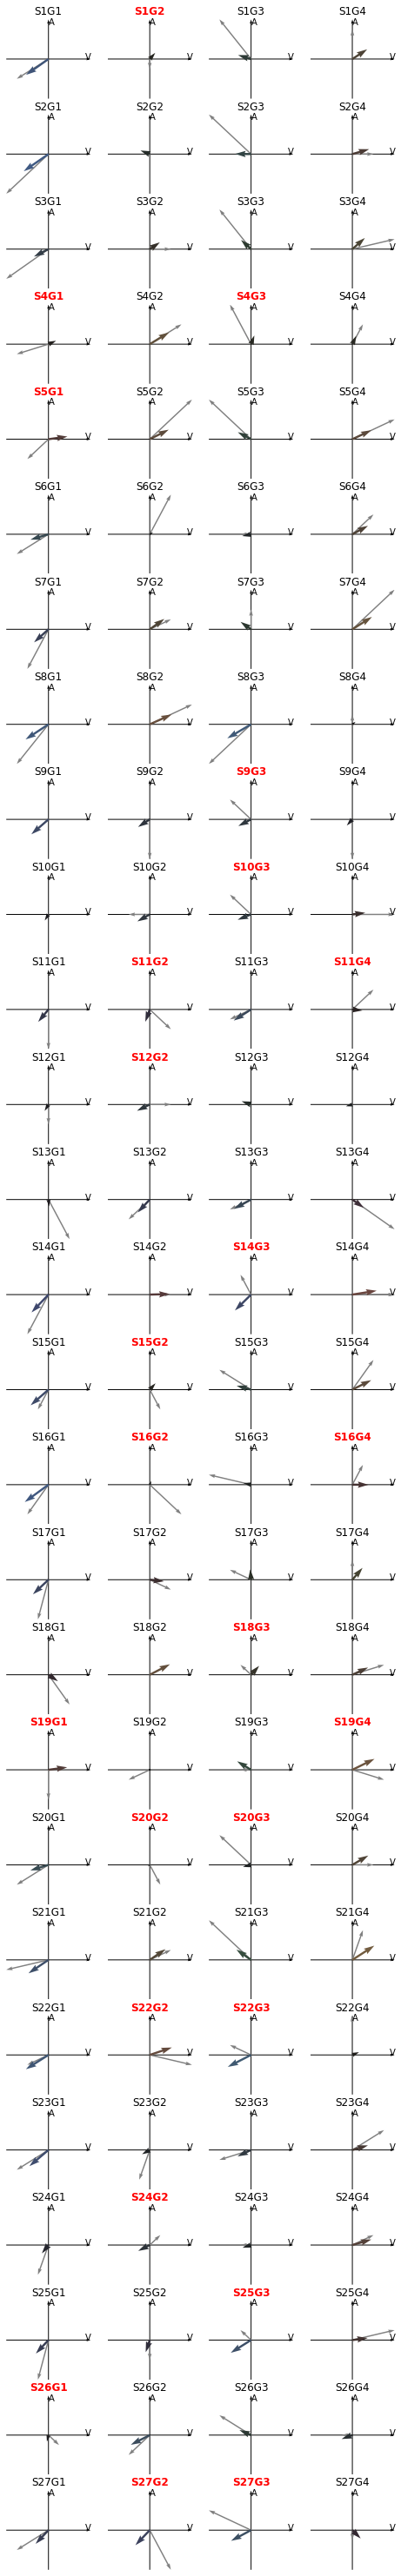

In [13]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 0 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
